## process Ceph Perf Data 

### Get internal perf data:

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
import pandas as pd
import json

# perf data
with open('dump-state-48.json') as f:
  data = json.load(f)
#------------ OSD ------------#
op_num = data['osd']['op'] # total number of ops
op_in_bytes = data['osd']['op_in_bytes'] # total bytes of ops
op_lat = data['osd']['op_latency']['avgtime'] # avg op latency in Ceph(from msg received to io finished in BlueStore)
op_w_num = data['osd']['op_w'] # total number of write ops
op_w_in_bytes = data['osd']['op_w_in_bytes'] # total bytes of write ops
op_w_lat = data['osd']['op_w_latency']['avgtime'] # avg write op latency in Ceph
op_queueing_lat = data['osd']['osd_op_queueing_time']['avgtime'] # avg lat for op in sharded op queue
osd_find_metadata_lat = data['osd']['osd_find_obc_lat']['avgtime'] # avg lat for reading metadata(cache or disk)
pg_num = data['osd']['numpg'] # total number of pgs(could also be number of rbd objects(4MB bu default))
#------------ RocksDB ------------#
kv_submit = data['rocksdb']['submit_transaction']
kv_submit_sync = data['rocksdb']['submit_transaction_sync']
kv_submit_lat = data['rocksdb']['submit_latency']['avgtime']
kv_Submit_lat_sync = data['rocksdb']['submit_sync_latency']['avgtime']
#------------ BlueStore ------------#
kv_flush_lat = data['bluestore']['kv_flush_lat']['avgtime'] # bdev->flush()
kv_commit_lat = data['bluestore']['kv_commit_lat']['avgtime'] # RocksDB comitting latency
kv_sync_lat = data['bluestore']['kv_sync_lat']['avgtime'] # flush + commit. we consider this as service latency
bluestore_simple_writes_lat = data['bluestore']['bluestore_simple_writes_lat']['avgtime'] # enter BlueStore to return to client for simple writes
bluestore_deferred_writes_lat = data['bluestore']['bluestore_deferred_writes_lat']['avgtime'] # enter BlueStore to return to client for deferred writes
bluestore_writes_lat = data['bluestore']['bluestore_writes_lat']['avgtime'] # enter BlueStore to return to client
bluestore_kv_queueing_lat = data['bluestore']['bluestore_kv_queue_time']['avgtime'] # avg lat for txc in kv_queue
bluestore_simple_async_io_lat = data['bluestore']['bluestore_simple_async_io_lat']['avgtime'] # async data io latency for simple writes
bluestore_deferred_async_io_lat = data['bluestore']['bluestore_deferred_async_io_lat']['avgtime'] # async data io latency for deferred writes
bluestore_onode_hits = data['bluestore']['bluestore_onode_hits'] # onode hit in cache
bluestore_onode_misses = data['bluestore']['bluestore_onode_misses'] # onode miss in cache
bluestore_extents = data['bluestore']['bluestore_extents'] # number of extents
bluestore_blobs = data['bluestore']['bluestore_blobs'] # number of blobs
bluestore_write_big = data['bluestore']['bluestore_write_big'] # number of big writes(simple writes)
bluestore_write_small = data['bluestore']['bluestore_write_small'] # number of small writes(could be simple or deferred)
bluestore_write_small_deferred = data['bluestore']['bluestore_write_small_deferred'] # number of deferred writes

In [2]:
print("========================================\n")
print("latency of queueing op in OSD op_queue:",'%f' % (op_queueing_lat),"s")
print("latency of processing async io:",'%f' % (bluestore_simple_async_io_lat),"s")
print("latency of queueing txc in BlueStore kv_queue:",'%f' % (bluestore_kv_queueing_lat),"s")
print("latency of processing txc:",'%f' % (kv_sync_lat),"s")
print("sum:",'%f' % (op_queueing_lat+bluestore_simple_async_io_lat+bluestore_kv_queueing_lat+kv_sync_lat),"s")

print("========================================\n")
print("latency of all ops:",'%f' % (op_lat),"s")
print("latency of write ops:",'%f' % (op_w_lat),"s")
print("w_op / op:","{:.3%}".format(op_w_num/op_num))
print("========================================\n")



latency of queueing op in OSD op_queue: 0.000094 s
latency of processing async io: 0.000150 s
latency of queueing txc in BlueStore kv_queue: 0.000656 s
latency of processing txc: 0.000878 s
sum: 0.001777 s

latency of all ops: 0.003484 s
latency of write ops: 0.003484 s
w_op / op: 99.996%



### Get benchmark data:

Average Workload Latency = 0.006316658060552 s
Average Throughput = 29.662519454956055 MB/s


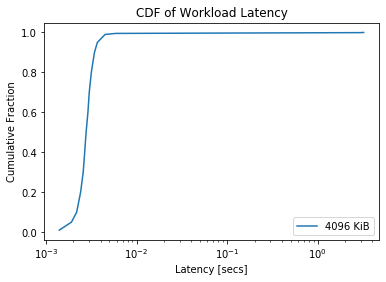

In [3]:
# workload latency
with open('dump-fio-bench-48.json') as f:
  data1 = json.load(f)
avg_lat = data1['jobs'][0]['write']['clat_ns']['mean']/1000000000
avg_throughput = data1['jobs'][0]['write']['bw_bytes']/1048576
print("Average Workload Latency =",avg_lat,"s")
print("Average Throughput =",avg_throughput,"MB/s")
x2 = []
y2 = []
for key, value in data1['jobs'][0]['write']['clat_ns']['percentile'].items():
    x2.append(value/1000000000)
    y2.append(float(key)/100)
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(x2, y2, label='4096 KiB')
ax.set(xlabel='Latency [secs]', ylabel='Cumulative Fraction', title='CDF of Workload Latency')
plt.legend()
plt.show()
plt.close()

### BlueStore latencies:

(1) BlueStore latency: from entering BlueStore to kv committed(STATE_KV_DONE). It contains both simple/deferred writes.

bluestore latency over selected datapoints= 0.0019693698505699763 s
bluestore latency over for all datapoints= 0.002002162254155914 s


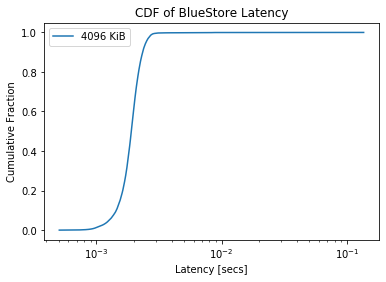

In [4]:
x1 = []
y1 = []
f1='dump_bluestore_lat_vec.csv'
data1=read_csv(f1, header=0, skiprows=20000, nrows=100000, parse_dates=True, squeeze=True).sort_values(ignore_index=True)
avg_bs_lat_partial = sum(data1) / len(data1)
alldata1 = read_csv(f1, header=0, parse_dates=True, squeeze=True)
avg_bs_lat_all = sum(alldata1) / len(alldata1)
print("bluestore latency over selected datapoints=",avg_bs_lat_partial,"s")
print("bluestore latency over for all datapoints=",avg_bs_lat_all,"s")
for i in range(0, 10000, 2):
    x1.append(data1[int(i/10000. * len(data1))])
    y1.append(i/10000.)
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(x1, y1, label='4096 KiB')
ax.set(xlabel='Latency [secs]', ylabel='Cumulative Fraction', title='CDF of BlueStore Latency')
plt.legend()
plt.show()
plt.close()

(2) Async IO latency: from aio_submit(STATE_PREPARE) to aio_finish callback(STATE_IO_DONE)

async io latency over selected datapoints= 0.0001404974833300016 s
async io latency for all datapoints= 0.000150022332859011 s


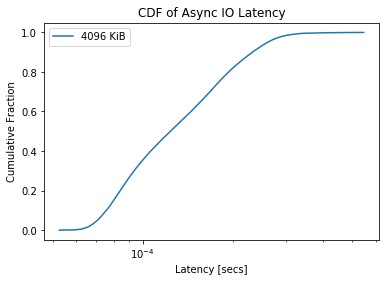

In [5]:
x1 = []
y1 = []
f1='dump_simple_asyncio_lat_vec.csv'
data1=read_csv(f1, header=0, skiprows=20000, nrows=100000, parse_dates=True, squeeze=True).sort_values(ignore_index=True)
avg_aio_lat = sum(data1) / len(data1)
alldata1 = read_csv(f1, header=0, parse_dates=True, squeeze=True)
avg_aio_lat_all = sum(alldata1) / len(alldata1)
print("async io latency over selected datapoints=",avg_aio_lat,"s")
print("async io latency for all datapoints=",avg_aio_lat_all,"s")
for i in range(0, 10000, 2):
    x1.append(data1[int(i/10000. * len(data1))])
    y1.append(i/10000.)
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(x1, y1, label='4096 KiB')
ax.set(xlabel='Latency [secs]', ylabel='Cumulative Fraction', title='CDF of Async IO Latency')
plt.legend()
plt.show()
plt.close()

(3) Service latency: flush() and commit() by kv_sync thread. If it's simple writes, only metadata is committed. If it's deferred writes, data and metadata is committed. 

async io latency over selected datapoints= 0.0008942850444600002 s
async io latency for all datapoints= 0.0008988416903602392 s


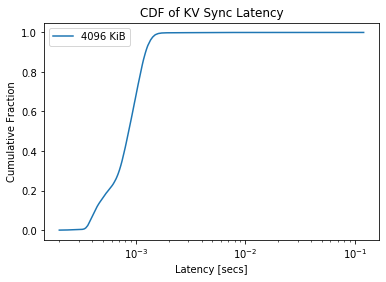

In [6]:
x1 = []
y1 = []
f1='dump_kv_sync_lat_vec.csv'
data1=read_csv(f1, header=0, skiprows=20000, nrows=100000, parse_dates=True, squeeze=True).sort_values(ignore_index=True)
avg_kv_sync_lat = sum(data1) / len(data1)
alldata1 = read_csv(f1, header=0, parse_dates=True, squeeze=True)
avg_kv_sync_lat_all = sum(alldata1) / len(alldata1)
print("async io latency over selected datapoints=",avg_kv_sync_lat,"s")
print("async io latency for all datapoints=",avg_kv_sync_lat_all,"s")
for i in range(0, 10000, 2):
    x1.append(data1[int(i/10000. * len(data1))])
    y1.append(i/10000.)
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(x1, y1, label='4096 KiB')
ax.set(xlabel='Latency [secs]', ylabel='Cumulative Fraction', title='CDF of KV Sync Latency')
plt.legend()
plt.show()
plt.close()